In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os
import torch
import librosa

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from datasets import AudioDataset

In [5]:
class DNNModel(nn.Module):
    def __init__(self, feat_dim):
        super(DNNModel, self).__init__()
        self.feat_dim = feat_dim
        self.hidden = 64
        
        self.linear1 = nn.Linear(self.feat_dim, 128)
        self.linear2 = nn.Linear(128, self.hidden)
        self.linear3 = nn.Linear(self.hidden, 32)
        self.linear4 = nn.Linear(32, 10)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()
    def forward(self, x):
        """
        Inputs: 
            x: [batch, seq, feature]
        """
        x = self.linear1(x)
        x = self.dropout(x)
        x = self.relu(x)
        
        x = self.linear2(x)
        x = self.dropout(x)
        x = self.relu(x)
        
        x = self.linear3(x)
        x = self.dropout(x)
        x = self.relu(x)
        
        y = self.linear4(x)
        return y

In [3]:
# path to urban sound 8k
data_root = "/home/tiz007/228/228_data/UrbanSound8K/"
# path to label
label_path = "/home/tiz007/228/228_data/UrbanSound8K/metadata/UrbanSound8K.csv"  

In [4]:
def lr_schedule(epoch, init_lr):
    if epoch <20:
        return init_lr
    elif epoch>=20 and epoch<40:
        return init_lr/10
    elif epoch>=40 and epoch <80:
        return init_lr/100
    else:
        return init_lr/1000

In [5]:
def train(MAX_EPOCH = 100):

    eval_interval = 5
    
    # initialize dataset (feature can be "mfcc", "spec", "mel_raw")
    audio_dataset = AudioDataset(3, DataRoot=data_root, LabelPath=label_path, feature="mel_mean", mode="train")

    # define lstm model
    dnn_model = DNNModel(128)

    # to gpu
    dnn_model = dnn_model.cuda()
    # initialize dataloader
    data_loader = torch.utils.data.DataLoader(audio_dataset, batch_size=32, shuffle=True, num_workers=1)

    # loss function
    loss_fn = nn.CrossEntropyLoss().cuda()

    # lr
    learning_rate = 1e-3

    # initialize optimizer
    optimizer = torch.optim.Adam(dnn_model.parameters(), lr=learning_rate)
    
    # initialize logger
    train_acc = []
    test_acc = []
    
    train_loss = []
    test_loss = []
    
    for epoch in range(MAX_EPOCH):
        # iterate through dataset
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr_schedule(epoch, learning_rate)
            
        # initialize epoch stat
        correct_num = 0
        total_num = 0
        loss_sum = 0

        for idx, data in enumerate(data_loader):
            #print(idx)
            train_data, labels = data
            
            #train_data = train_data.type(torch.float32)/255
            
            # data to gpu
            train_data = train_data.cuda()
            labels = labels.cuda()

            prob = dnn_model(train_data)   
            loss = loss_fn(prob, labels)

            output = prob.argmax(1)
            
            loss_sum += loss.item()*float(labels.shape[0])
            correct_num += (output==labels).sum().double()
            total_num += float(labels.shape[0])

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
            
        train_acc.append(correct_num/total_num)
        train_loss.append(loss_sum/total_num)

        print("epoch: {} acc: {:.4} avg loss: {:.4f}".format(epoch, correct_num/total_num, loss_sum/total_num))
        
        test_acc_, test_loss_ = test(dnn_model)
        test_acc.append(test_acc_)
        test_loss.append(test_loss_)
        
    
    plt.figure()
    plt.plot(np.arange(MAX_EPOCH), train_acc)
    plt.plot(np.arange(MAX_EPOCH), test_acc)
    plt.title("accuracy")
    plt.legend(["train","val"])
    
    plt.figure()
    plt.plot(np.arange(MAX_EPOCH), train_loss)
    plt.plot(np.arange(MAX_EPOCH), test_loss)
    plt.title("loss")
    plt.legend(["train","val"])

In [6]:
def test(model, ):
    test_dataset = AudioDataset(3, DataRoot=data_root, LabelPath=label_path, feature="mel_mean", mode="test")
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=1)
    
    model.eval()

    # loss function
    loss_fn = nn.CrossEntropyLoss().cuda()
    
    correct_num = 0
    total_num = 0
    loss_sum = 0
    
    for idx, data in enumerate(test_loader):
        test_data, labels = data
        test_data = test_data.cuda()
        labels = labels.cuda()
        
        test_data = test_data.cuda()

        prob = model(test_data)   
        loss = loss_fn(prob, labels)
        
        output = prob.argmax(1)
        
        correct_num += (output==labels).sum().double()
        loss_sum += loss.item()*float(labels.shape[0])
        total_num += float(labels.shape[0])
        
    model.train()

    print("##Testing## epoch acc: {:.4}".format(correct_num/total_num))
    return correct_num/total_num, loss_sum/total_num

verify mel_mean feature success
epoch: 0 acc: 0.1526 avg loss: 2.3052
verify mel_mean feature success
##Testing## epoch acc: 0.2638
epoch: 1 acc: 0.2151 avg loss: 2.1611
verify mel_mean feature success
##Testing## epoch acc: 0.3222
epoch: 2 acc: 0.2452 avg loss: 2.0794
verify mel_mean feature success
##Testing## epoch acc: 0.3276
epoch: 3 acc: 0.2868 avg loss: 2.0251
verify mel_mean feature success
##Testing## epoch acc: 0.3373
epoch: 4 acc: 0.3032 avg loss: 1.9758
verify mel_mean feature success
##Testing## epoch acc: 0.3384
epoch: 5 acc: 0.3213 avg loss: 1.9205
verify mel_mean feature success
##Testing## epoch acc: 0.373
epoch: 6 acc: 0.3352 avg loss: 1.8666
verify mel_mean feature success
##Testing## epoch acc: 0.3405
epoch: 7 acc: 0.3449 avg loss: 1.8373
verify mel_mean feature success
##Testing## epoch acc: 0.3568
epoch: 8 acc: 0.3508 avg loss: 1.7854
verify mel_mean feature success
##Testing## epoch acc: 0.3427
epoch: 9 acc: 0.3697 avg loss: 1.7662
verify mel_mean feature success

##Testing## epoch acc: 0.3492
epoch: 82 acc: 0.5007 avg loss: 1.3861
verify mel_mean feature success
##Testing## epoch acc: 0.3492
epoch: 83 acc: 0.5138 avg loss: 1.3716
verify mel_mean feature success
##Testing## epoch acc: 0.3492
epoch: 84 acc: 0.5115 avg loss: 1.3783
verify mel_mean feature success
##Testing## epoch acc: 0.3492
epoch: 85 acc: 0.5079 avg loss: 1.3725
verify mel_mean feature success
##Testing## epoch acc: 0.3492
epoch: 86 acc: 0.5106 avg loss: 1.3725
verify mel_mean feature success
##Testing## epoch acc: 0.3492
epoch: 87 acc: 0.5063 avg loss: 1.3738
verify mel_mean feature success
##Testing## epoch acc: 0.3492
epoch: 88 acc: 0.5115 avg loss: 1.3683
verify mel_mean feature success
##Testing## epoch acc: 0.3492
epoch: 89 acc: 0.513 avg loss: 1.3729
verify mel_mean feature success
##Testing## epoch acc: 0.3492
epoch: 90 acc: 0.5062 avg loss: 1.3625
verify mel_mean feature success
##Testing## epoch acc: 0.3503
epoch: 91 acc: 0.5117 avg loss: 1.3766
verify mel_mean feature

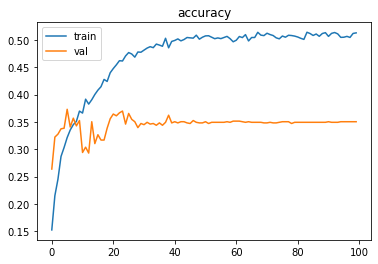

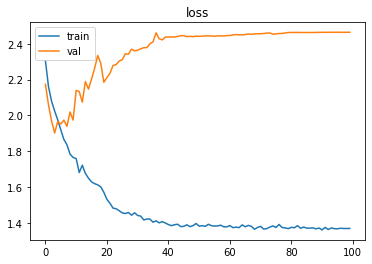

In [7]:
train(100)

In [7]:
model = DNNModel(128)

num = 0
for parameter in model.parameters():
    num += torch.numel(parameter)
print(num)

27178
